In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm


In [7]:
class DriftedBanditEnv:
    def __init__(self, arm_count=10, base_value=5.0, walk_sigma=0.01):
        self.arm_count = arm_count
        self.true_means = np.full(arm_count, base_value, dtype=float)
        self.walk_sigma = walk_sigma

    def sample(self, arm_index):
        payout = np.random.normal(self.true_means[arm_index], 1.0)
        self.true_means += np.random.normal(0.0, self.walk_sigma, self.arm_count)
        return payout


In [8]:
class AdaptiveLearner:
    def __init__(self, arm_total, explore_rate=0.1, step_size=0.1, buffer_len=100):
        self.arm_total = arm_total
        self.explore_rate = explore_rate
        self.step_size = step_size
        self.buffer_len = buffer_len

        self.value_est = np.full(arm_total, 5.0)
        self.pick_counts = np.zeros(arm_total)

        self.reward_buffer = np.zeros(buffer_len)
        self.buffer_idx = 0

    def select_arm(self):
        if np.random.random() < self.explore_rate:
            return np.random.randint(self.arm_total)
        return np.argmax(self.value_est)

    def learn(self, arm_id, outcome):
        self.pick_counts[arm_id] += 1

        self.reward_buffer[self.buffer_idx] = outcome
        self.buffer_idx = (self.buffer_idx + 1) % self.buffer_len

        avg_r = self.reward_buffer.mean()
        var_r = self.reward_buffer.var()

        self.value_est[arm_id] += self.step_size * (outcome - avg_r) / (1e-10 + np.sqrt(var_r))

        self.explore_rate = max(0.01, self.explore_rate * 0.999)
        self.step_size = max(0.01, self.step_size * 0.999)


In [9]:
def execute_single_trial(trial_id):
    total_iters = 10000
    env = DriftedBanditEnv()
    learner = AdaptiveLearner(env.arm_count)

    reward_trace = np.zeros(total_iters)
    optimal_trace = np.zeros(total_iters, dtype=int)

    for idx in range(total_iters):
        chosen = learner.select_arm()
        outcome = env.sample(chosen)
        learner.learn(chosen, outcome)

        reward_trace[idx] = outcome
        optimal_trace[idx] = int(chosen == np.argmax(env.true_means))

    return reward_trace, optimal_trace


In [10]:

def run_batch_trials(batch_size=100):
    with Pool() as workers:
        outcome_list = list(
            tqdm(
                workers.imap(execute_single_trial, range(batch_size)),
                total=batch_size
            )
        )

    reward_stack = np.array([res[0] for res in outcome_list])
    optimal_stack = np.array([res[1] for res in outcome_list])

    return reward_stack, optimal_stack


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


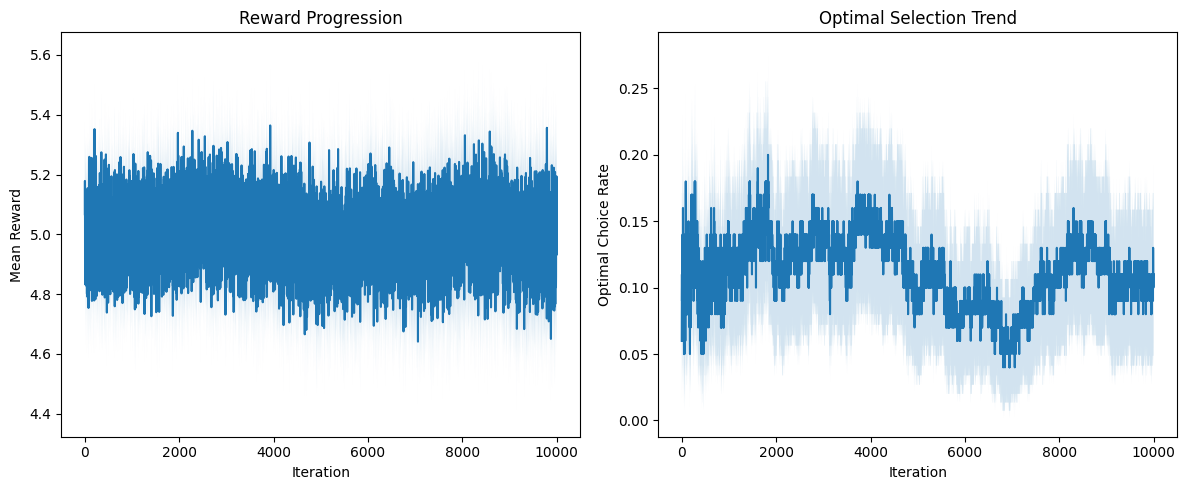

In [11]:
def visualize_outcomes(reward_mat, optimal_mat):
    plt.figure(figsize=(12, 5))

    # --- Reward Plot ---
    plt.subplot(1, 2, 1)
    avg_r = reward_mat.mean(axis=0)
    std_r = reward_mat.std(axis=0)

    plt.plot(avg_r)
    plt.fill_between(
        np.arange(len(avg_r)),
        avg_r - 1.96 * std_r / np.sqrt(100),
        avg_r + 1.96 * std_r / np.sqrt(100),
        alpha=0.2
    )
    plt.xlabel("Iteration")
    plt.ylabel("Mean Reward")
    plt.title("Reward Progression")

    # --- Optimal Selection Plot ---
    plt.subplot(1, 2, 2)
    avg_opt = optimal_mat.mean(axis=0)
    std_opt = optimal_mat.std(axis=0)

    plt.plot(avg_opt)
    plt.fill_between(
        np.arange(len(avg_opt)),
        avg_opt - 1.96 * std_opt / np.sqrt(100),
        avg_opt + 1.96 * std_opt / np.sqrt(100),
        alpha=0.2
    )
    plt.xlabel("Iteration")
    plt.ylabel("Optimal Choice Rate")
    plt.title("Optimal Selection Trend")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    r_stack, o_stack = run_batch_trials()
    visualize_outcomes(r_stack, o_stack)
